<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок-для-обучения" data-toc-modified-id="Подготовка-выборок-для-обучения-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка выборок для обучения</a></span></li><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Линейная-модель-с-L1-регуляризацией" data-toc-modified-id="Линейная-модель-с-L1-регуляризацией-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная модель с L1 регуляризацией</a></span></li><li><span><a href="#Линейная-модель-с-L2-регуляризацией" data-toc-modified-id="Линейная-модель-с-L2-регуляризацией-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная модель с L2 регуляризацией</a></span></li><li><span><a href="#Модель-Дерево-решений" data-toc-modified-id="Модель-Дерево-решений-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель Дерево решений</a></span></li><li><span><a href="#Модель-бустинга-LGBMRegressor" data-toc-modified-id="Модель-бустинга-LGBMRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель бустинга LGBMRegressor</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
!pip install statsmodels -q

In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,TimeSeriesSplit

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error

# загружаем нужные модели
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#отключим предупреждения (в конце)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

#зададим формат окна
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Загрузим данные, выведем любые 5 строк для наглядной оценки данных, оценим общую информацию о данных

In [3]:
#функция для загрузки данных в датафрейм
def download(file,sep=','):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'

    if os.path.exists(path_1):
        data = pd.read_csv(path_1, sep)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2, sep)
    else:
        print('Something is wrong')
        
    return data 

In [4]:
#загрузим данные из файла 
taxi = download('taxi')

#выведем любые 5 строк
taxi.sample(5)

,datetime,num_orders
12024,2018-05-23 12:00:00,6
22275,2018-08-02 16:30:00,16
26230,2018-08-30 03:40:00,40
10684,2018-05-14 04:40:00,2
24850,2018-08-20 13:40:00,18


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


 - Данные представлены 2-мя столбцами с временем заказа и кол-вом заказов, 26496-тью строками.
 - Пропуски отсутствуют
 - Тип столбца со временем некорректный: переведем его из строкового типа во временной.

Перед манипуляциями со столбцом со временем заказов проверим нет ли дубликатов по столбцу время.
Установим время в качестве индекса

In [6]:
print(f'Кол-во полных дубликатов: {taxi.duplicated().sum()} \nКол-во дубликатов времени: {taxi["datetime"].duplicated().sum()}')

Кол-во полных дубликатов: 0 
Кол-во дубликатов времени: 0


In [7]:
#поменяем формат столбца со временем
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
#сделаем столбец со временем индексом
taxi = taxi.set_index('datetime')
#посмотрим что получилось
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
#отсортируем индесы таблицы
taxi = taxi.sort_index()
# проверим, что все прошло корректно
taxi.index.is_monotonic

True

Выведем период анализа

In [9]:
f'Данные за период: {taxi.index.min()} - {taxi.index.max()}'

'Данные за период: 2018-03-01 00:00:00 - 2018-08-31 23:50:00'

Выполним ресемплирование данных по одному часу, суммируя значения в рамках каждого часа, поскольку будем прогнозировать суммарное кол-во заказов на следующий час.

In [10]:
taxi = taxi.resample('1H').sum()

**Вывод по подготовке**:
 - данные представлены 2-мя столбцами: время заказа и кол-во заказов,
 - пропуски, дубликаты полные, в т.ч.дубликаты времени заказа отсутствуют,
 - период анализа: с 1 марта по 31 августа 2018 года,
 - время заказа переведено в индексы,
 - произведено ресемпелирование по сумме за 1 час

## Анализ

Проведем анализ тренда/сезонности/шумов по всей выборке, а затем на последнем месяце (август)

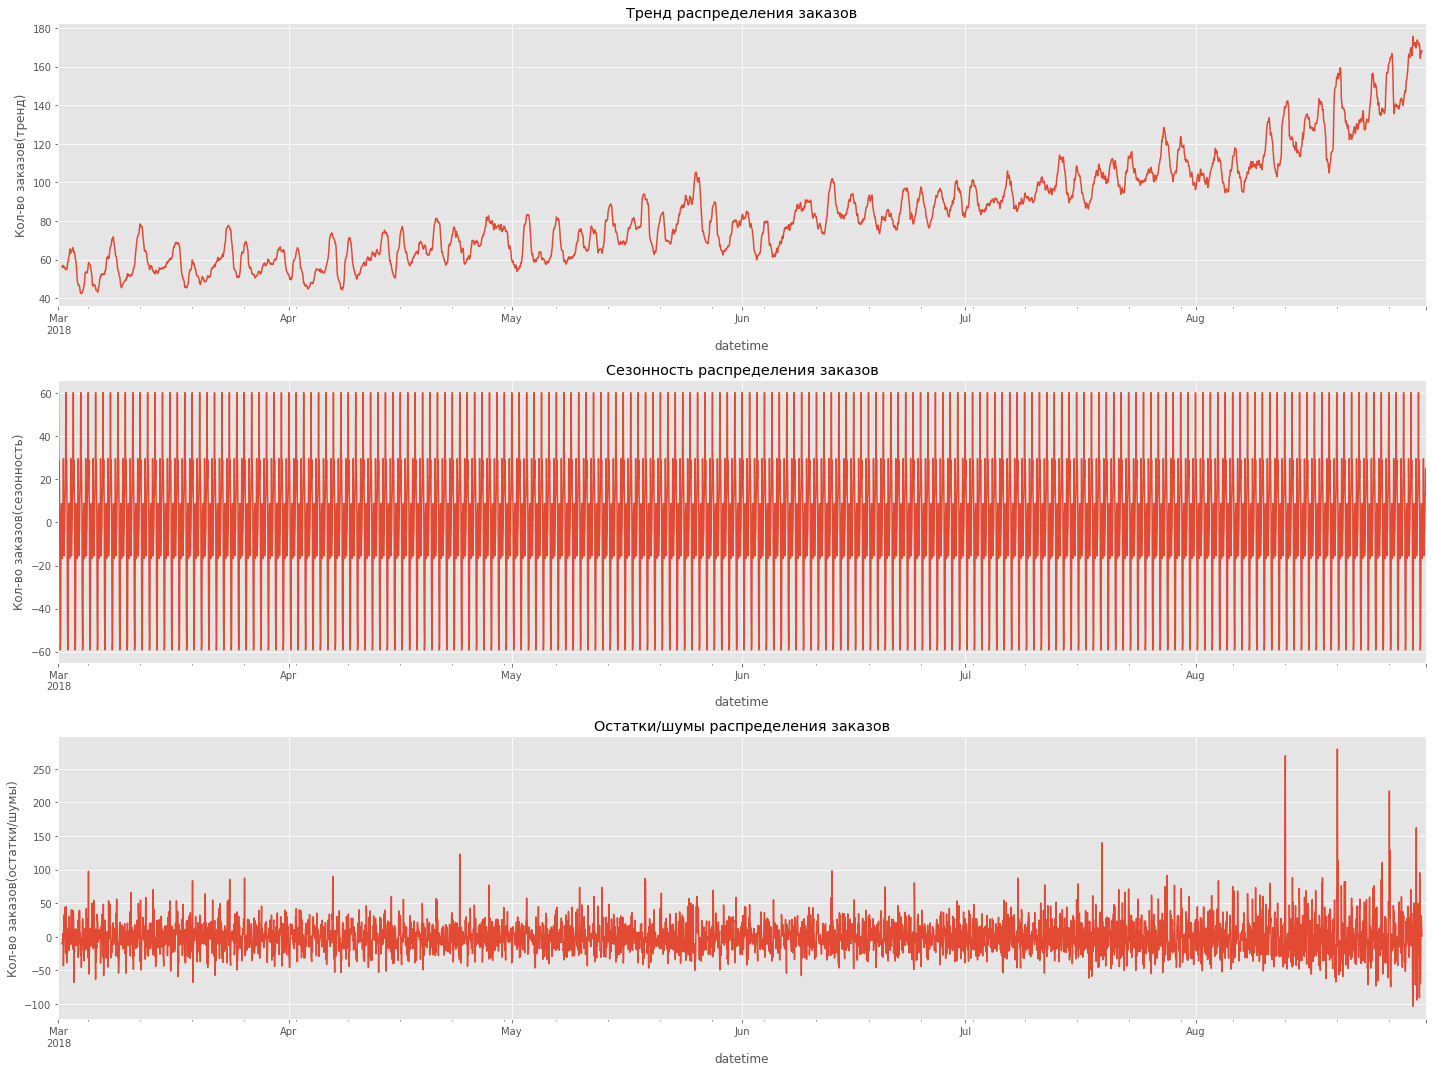

In [11]:
#постороим график тренда распределения кол-ва заказов за весь период
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi)
decomposed.trend.plot(figsize=(20, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд распределения заказов')
plt.ylabel('Кол-во заказов(тренд)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность распределения заказов')
plt.ylabel('Кол-во заказов(сезонность)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки/шумы распределения заказов')
plt.ylabel('Кол-во заказов(остатки/шумы)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.tight_layout()

Трэнд по месяцам:
 - имеет тенденцию роста в течение года: возможно увеличения летом связано с сезоном отпусков, рост к осени.
 - имеет скорее более сложную, нелинейную зависимость от времени (квадратичная или экспоненциальная). Учитывая, что нам требуется предсказать значение только на час вперед - будем считать зависимость линейной.
 
Сезонность:
 - прослеживается внутри каждого дня - рассмотрии более приближенно в разрезе августа,
 
Шумы: 
 - присутствуют некоторые шумы, поэтому для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов - сутки/возможно неделя(рассмотрим далее).
 
Оценим тренд и сезонность последнего имеющегося месяца(август) 

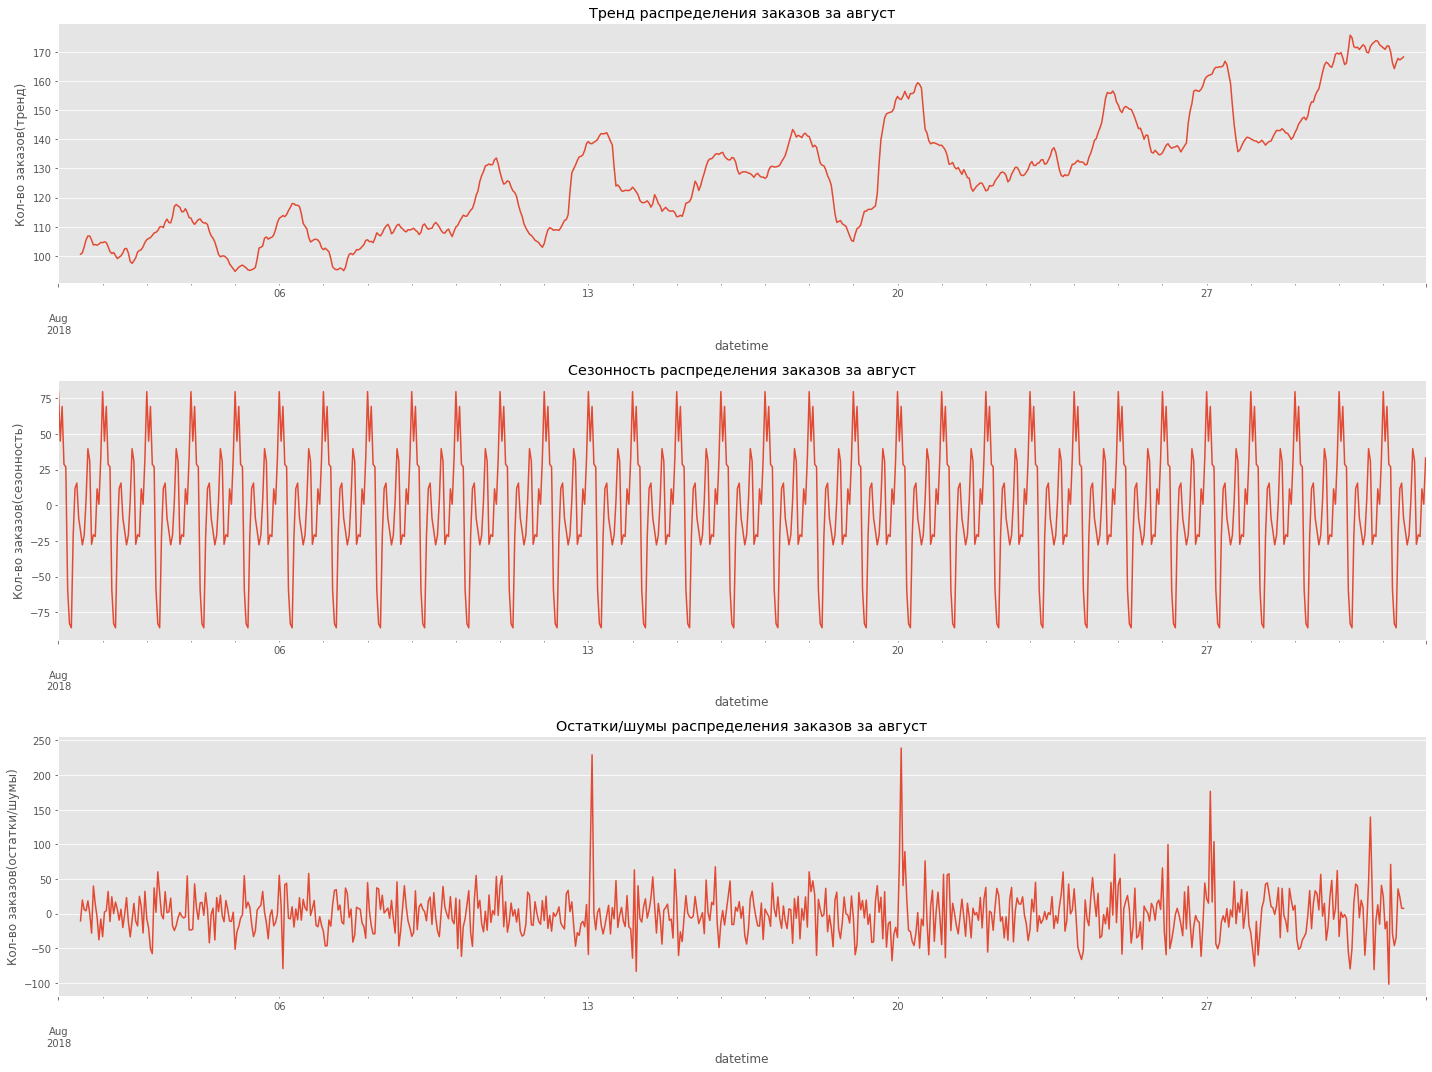

In [12]:
#постороим график тренда/сезонности/шумов распределения кол-ва заказов за август
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi['2018-08':'2018-08'])
plt.figure(figsize=(20, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд распределения заказов за август')
plt.ylabel('Кол-во заказов(тренд)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность распределения заказов за август')
plt.ylabel('Кол-во заказов(сезонность)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки/шумы распределения заказов за август')
plt.ylabel('Кол-во заказов(остатки/шумы)')
plt.subplots_adjust(wspace=1,hspace = 1);
plt.tight_layout()

Анализ по данным за август 2018:
- Трэнд показывает линейный рост количества заказов в течение месяца, 
- Прослеживается сезонность в интервале суток:скорее всего спад ночью, большая часть заказов в дневное время - проанализируем далее,
- "Шумы": среднее значение близко к постоянному, при этом периодически возникают большие всплески - причем эти всплески выше, чем было в предыдущие месяца, возможно связано с праздниками или иными не событиями.
 

Оценим распределение также по дням недели и часам: создадим признаки с днем недели, часом. Создавать признак месяц не имеет смысла ( у нас только один и то неполный год), просто день месяца тоже будет непоказателен.

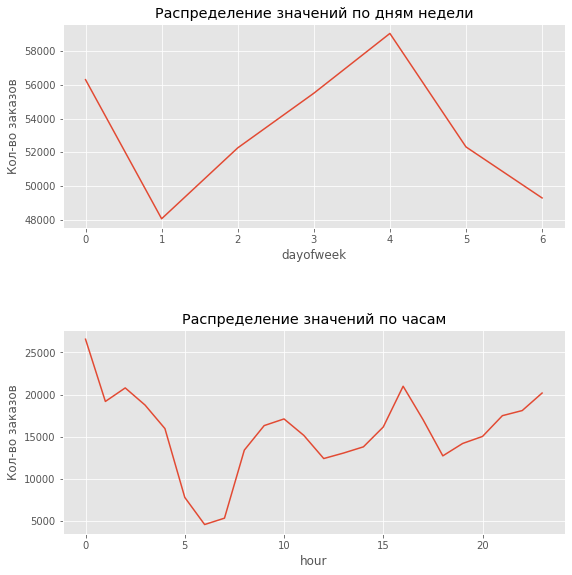

In [13]:
#создадим признаки с днем недели, часом
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
#Построим графики количества заказов
plt.figure(figsize=(9,15))
plt.subplot(3,1,1)
taxi.groupby('dayofweek')['num_orders'].sum().plot();
plt.title('Распределение значений по дням недели');
plt.ylabel('Кол-во заказов');
plt.subplots_adjust(wspace=0.5,hspace = 0.5);
plt.subplot(3,1,2)
taxi.groupby('hour')['num_orders'].sum().plot();
plt.title('Распределение значений по часам');
plt.ylabel('Кол-во заказов');

 - День недели: имеет 2 пика - пятница и понедельник, понедельник (0 это понедельник) - возвращение людей после выходных, далее спад во вторник и постепенный рост к пятнице - опять же улетают на выходные,
 - Час: наблюдается постепенный рост с 6-7 часов утра в течение дня к вечеру, пик приходится к полуночи, далее спад до 5 утра.
 
Исходя из зависимости от времени суток и дня недели, лаг для отстающего значения и скользящее среднее стоит создавать как минимум по кол-ву часов в сутках 24 ( в идеале до 24 умножить на 7, с учетом зависимости в т.ч. от дня недели). Остановимся на лаге в 48 часов, чтобы учесть изменение в заказе после пиковых дней недели (например, с понедельника на вторник, с пятницы на субботу)

In [14]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    frame = data.copy()
    for lag in range(1, max_lag + 1):
        frame['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    frame['rolling_mean'] = frame['num_orders'].shift().rolling(rolling_mean_size).mean()
    return frame

In [15]:
#создадим новые признаки
taxi = make_features(taxi, 48, 48)

Оценим распределение данных по кол-ву заказов и созданному признаку скользящему среднему для визуальной оценки является ли наш временной ряд стационарным

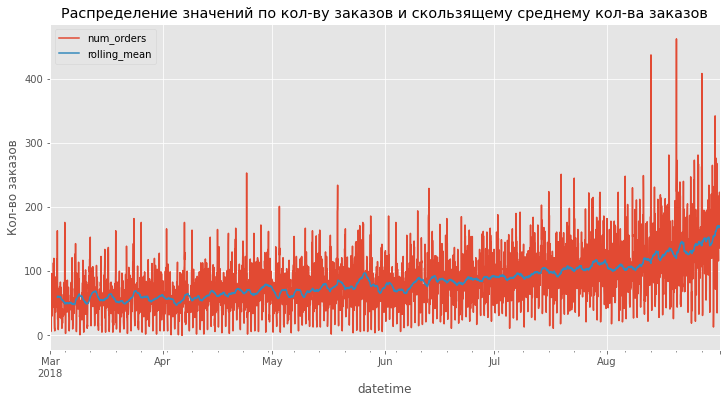

In [16]:
taxi[['num_orders','rolling_mean']].plot(figsize=(12,6));
plt.title('Распределение значений по кол-ву заказов и скользящему среднему кол-ва заказов');
plt.ylabel('Кол-во заказов');

При визуальной оценке есть некоторые сомнения в стационарности ряда, оценим стационарность ряда с помощью расширенного теста Дики-Фуллера.

В тесте Дики-Фуллера, используются следующие нулевая и альтернативная гипотезы:
- H0 : временной ряд является нестационарным. 
- H1 : временной ряд является стационарным.

Оценим p-значение для теста с уровнем значимости  α=5%.

In [17]:
#выполним тест Дики-Фуллера
st_test = adfuller(taxi['num_orders'])

In [18]:
#выведем решение об отвержениии/не отвержении нулевой гипотезы 
if st_test[1] < 0.05:
    print('Согласно теста Дики-Фуллера: \nНулевая гипотеза отвергнута (p-value меньше 5%) - Ряд стационарный')
else:
    print('Согласно теста Дики-Фуллера: \nНулевая гипотеза не может быть отвергнута (p-value больше 5%) - Ряд нестационарный')

Согласно теста Дики-Фуллера: 
Нулевая гипотеза отвергнута (p-value меньше 5%) - Ряд стационарный


Т.о., наш временной ряд является стационарным

**Вывод по анализу**:
 - трэнд по месяцам имеет более сложную зависимость от времени (квадраичная или экспоненциальная), при этом для нашей задачи с учетом прогнозирования только на 1 час вперед можно считать зависимость линейной 
 - распределение сезонной части  выглядит стационарным в интервале суток:наблюдается постепенный рост с 6-7 часов утра в течение дня к вечеру, пик приходится к полуночи, далее спад до 5 утра.
 - день недели: имеет 2 пика - пятница и понедельник, понедельник (0 это понедельник) - возвращение людей после выходных, далее спад во вторник и постепенный рост к пятнице - опять же улетают на выходные,
 - "шумы": присутствуют некоторые шумы, поэтому для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов,
 - исходя из зависимости от времени суток и дня недели, лаг для отстающего значения и скользящее среднее стоит создавать как минимум по кол-ву часов в сутках 24 ( в идеале до 24 умножить на 7, с учетом зависимости в т.ч. от дня недели). Остановимся на лаге в 48 часов, чтобы учесть изменение в заказе после пиковых дней недели (например, с понедельника на вторник, с пятницы на субботу)
 - в рамках анализа созданы дополнительные признаки: день недели, час, а также отстающие значенияс лагом до 48 часов и скользящее среднее.
 - согласно теста Дики-Фуллера, наш временной ряд является стационарным.

## Обучение

### Подготовка выборок для обучения

In [19]:
#разобьем выборку на тренинговую и тестовую, удалим пропуски (образовались при создании отстающих значений)
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
#выделим целевой и прочие признаки
y_train = train['num_orders']
X_train = train.drop(['num_orders'],axis=1)
y_test = test['num_orders']
X_test = test.drop(['num_orders'],axis=1)

Мы уже создали признаки для работы модели с учетом предыдущих значений, но возможно стоит проверить, что прогноз константой даст более лучшую метрику

Оценим модель первым способом — прогнозом константой. 

In [20]:
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
print("RMSE:", mean_squared_error(test['num_orders'], pred_median)**0.5)

RMSE: 87.15277582981295



Оценим модель вторым способом — предыдущим значением ряда.

In [21]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
print("RMSE:", mean_squared_error(test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


RMSE меньше при предсказании по предыдущему значению, поэтому возьмем за основу работы модели этот принцип.

Далее рассмотрим несколько линейных моделей (с регуляризацией и без), дерево решений и модель бустинга. Подберем для каждой модели такие гиперпараметры, при которых метрика MSE, а соответственно RMSE будет меньше

### Линейная модель

In [22]:
# создадим пустой список для
models_rmse = []

# инициализируем модель
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
#зададим пустой словарь для перебора GridSearchCV
parameters = {}

In [23]:
#создадим объект-генератор разбиений для временного ряда при помощи TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [24]:
#произведем поиск лучшей модели и обучим ее 
grid_lr = GridSearchCV(
    model_lr,
    parameters,
    cv=tscv,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_lr.fit(X_train, y_train)

#посчитаем RMSE при кросс-валидации
rmse_lr = round((-grid_lr.best_score_) ** 0.5)

models_rmse.append([model_lr,grid_lr.best_params_, rmse_lr])

# выведем  RMSE при кросс-валидации
print('RMSE линейной модели на кросс-валидации: ' , rmse_lr)

RMSE линейной модели на кросс-валидации:  25


### Линейная модель с L1 регуляризацией

In [25]:
# инициализируем модель
model_lasso = Lasso(random_state=123)

In [26]:
model_lasso.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
    'alpha':range(1,20)
}

#произведем поиск лучше модели и обучим ее 
grid_lasso = GridSearchCV(
    model_lasso,
    parameters,
    cv=tscv,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_lasso.fit(X_train, y_train)

#посчитаем RMSE при кросс-валидации
rmse_lasso = round((-grid_lasso.best_score_) ** 0.5)

models_rmse.append([model_lasso,grid_lasso.best_params_, rmse_lasso])

# выведем параметры лучшей модели и RMSE при кросс-валидации
print('Параметры линейной модели с L1 регуляризацией: ' , grid_lasso.best_params_)
print('RMSE линейной модели с L1 регуляризацией на кросс-валидации: ' , rmse_lasso)

Параметры линейной модели с L1 регуляризацией:  {'alpha': 7}
RMSE линейной модели с L1 регуляризацией на кросс-валидации:  25


### Линейная модель с L2 регуляризацией

In [27]:
# инициализируем модель
model_ridge = Ridge(random_state=123)
model_ridge.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
    'alpha':range(1,20)
}

#произведем поиск лучше модели и обучим ее 
grid_ridge = GridSearchCV(
    model_ridge,
    parameters,
     cv=tscv,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_ridge.fit(X_train, y_train)

#посчитаем RMSE при кросс-валидации
rmse_ridge = round((-grid_ridge.best_score_) ** 0.5)

models_rmse.append([model_ridge,grid_ridge.best_params_, rmse_ridge])

# выведем параметры лучшей модели и RMSE при кросс-валидации
print('Параметры  линейной модели с L2 регуляризацией: ', grid_ridge.best_params_)
print('RMSE линейной модели с L2 регуляризацией на кросс-валидации: ' , rmse_ridge)

Параметры  линейной модели с L2 регуляризацией:  {'alpha': 19}
RMSE линейной модели с L2 регуляризацией на кросс-валидации:  25


### Модель Дерево решений

In [28]:
# инициализируем модель
model_dtr = DecisionTreeRegressor(random_state=123)
model_dtr.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
      'max_depth': range(1,11,2),
    'min_samples_split': range(2, 10),
        'min_samples_leaf': range(2, 10)
}

#произведем поиск лучше модели и обучим ее 
grid_dtr = GridSearchCV(
    model_dtr,
    parameters,
     cv=tscv,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_dtr.fit(X_train, y_train)

#посчитаем RMSE при кросс-валидации
rmse_dtr = round((-grid_dtr.best_score_) ** 0.5)

models_rmse.append([model_dtr,grid_dtr.best_params_, rmse_dtr])

# выведем параметры лучшей модели и RMSE при кросс-валидации
print('Парамтеры лучшей модели Дерева решений: ', grid_dtr.best_params_)
print('RMSE Дерева решений на кросс-валидации: ' , rmse_dtr)

Парамтеры лучшей модели Дерева решений:  {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
RMSE Дерева решений на кросс-валидации:  29


### Модель бустинга LGBMRegressor

In [29]:
# инициализируем модель
model_lgb = lgb.LGBMRegressor(random_state=123)
model_lgb.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
               'max_depth': range(1,11,2),
    'learning_rate': [0.1,0.5,0.9]
}

#произведем поиск лучше модели и обучим ее 
grid_lgb = GridSearchCV(
    model_lgb,
    parameters,
     cv=tscv,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_lgb.fit(X_train, y_train)

#посчитаем RMSE при кросс-валидации
rmse_lgb = round((-grid_lgb.best_score_) ** 0.5)

models_rmse.append([model_lgb,grid_lgb.best_params_, rmse_lgb])

# выведем параметры лучшей модели и RMSE при кросс-валидации
print('Параметры лучшей модели бустинга: ', grid_lgb.best_params_)
print('RMSE модели бустинга на кросс-валидации: ' , rmse_lgb)

Параметры лучшей модели бустинга:  {'learning_rate': 0.1, 'max_depth': 5}
RMSE модели бустинга на кросс-валидации:  24


### Выбор модели

In [30]:
#выведем таблицу со всеми моделями и метриками RMSE при кросс-валидации
models_rmse = pd.DataFrame(models_rmse, columns=['model','best_params','rmse_cv'])
models_rmse.sort_values(by='rmse_cv')

,model,best_params,rmse_cv
4,LGBMRegressor(random_state=123),"{'learning_rate': 0.1, 'max_depth': 5}",24
0,LinearRegression(),{},25
1,Lasso(random_state=123),{'alpha': 7},25
2,Ridge(random_state=123),{'alpha': 19},25
3,DecisionTreeRegressor(random_state=123),"{'max_depth': 5, 'min_samples_leaf': 8, 'min_s...",29


С небольшим отрывом лучшую метрику показала модель бустинга, поэтому далее будем тестировать значение метрики на ней.

## Тестирование

Посчитаем значение метрики RMSE выбранной модели на тестовой выборке

In [31]:
pred_lgb = grid_lgb.best_estimator_.predict(X_test)

print('RMSE лучшей модели LGBMRegressor на тестовой выборке: ',round(mean_squared_error(y_test,pred_lgb) ** 0.5,))

RMSE лучшей модели LGBMRegressor на тестовой выборке:  40


Значение метрики соответствует требованиям.

Построим график  предсказанных выбранной моделью значений и фактических значений

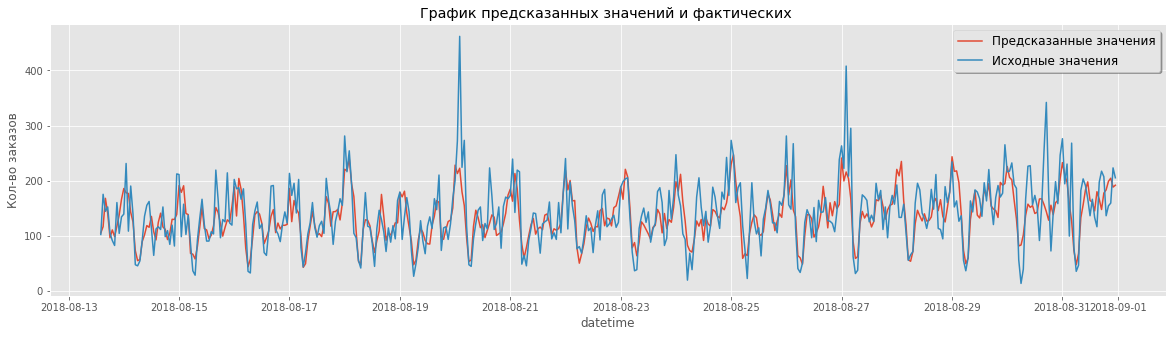

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(pd.Series(pred_lgb, index = y_test.index), label='Предсказанные значения')
ax.plot(y_test, label='Исходные значения')
legend = ax.legend(loc='upper right', shadow=True, fontsize= 12)
plt.title('График предсказанных значений и фактических ');
plt.ylabel('Кол-во заказов');
plt.xlabel('datetime');

Как видим, модель плохо предсказывает пиковые значения, являющиеся "шумами". Возможно для увеличения качества предсказания необходимо увеличить величину лага выше 48 часов, либо для учета годовой сезонности увеличить выборку периода анализа.

## Вывод


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Задача проекта - построить такую предсказательную модель. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Задача была решена 4-мя этапами:
  - 1) Подготовка. Выводу по этапу:
    - данные представлены 2-мя столбцами: время заказа и кол-во заказов,
    - пропуски, дубликаты полные, в т.ч.дубликаты времени заказа отсутствуют,
    - период анализа: с 1 марта по 31 августа 2018 года,
    - время заказа переведено в индексы,
    - произведено ресемпелирование по сумме заказов за 1 час.
  - 2)Анализ. Вывод по этапу:
    - трэнд по месяцам имеет более сложную зависимость от времени (квадратичная или экспоненциальная), при этом для нашей задачи с учетом прогнозирования только на 1 час вперед можно считать зависимость линейной 
    - распределение сезонной части  выглядит стационарным в интервале суток:наблюдается постепенный рост с 6-7 часов утра в течение дня к вечеру, пик приходится к полуночи, далее спад до 5 утра.
    - день недели: имеет 2 пика - пятница и понедельник, понедельник (0 это понедельник) - возвращение людей после выходных, далее спад во вторник и постепенный рост к пятнице - опять же улетают на выходные,
    - "шумы": присутствуют некоторые шумы, поэтому для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов,
    - исходя из зависимости от времени суток и дня недели, лаг для отстающего значения и скользящее среднее стоит создавать как минимум по кол-ву часов в сутках 24 ( в идеале до 24 умножить на 7, с учетом зависимости в т.ч. от дня недели). Остановимся на лаге в 48 часов, чтобы учесть изменение в заказе после пиковых дней недели (например, с понедельника на вторник, с пятницы на субботу)
    - в рамках анализа созданы дополнительные признаки: день недели, час, а также отстающие значенияс лагом до 48 часов и скользящее среднее.
    - согласно теста Дики-Фуллера, наш временной ряд является стационарным.
  - 3) Обучение моделей:
    - подготовлены тренировочная и тестовая выборки для обучения,
    - рассмотрено несколько линейных моделей (с регуляризацией и без), дерево решений и модель бустинга.  Для каждой модели подобраны такие гиперпараметры, при которых метрика MSE, а соответственно RMSE будет меньше,
    - с небольшим отрывом лучшую метрику RMSE при кросс-валидации показала модель бустинга LGBMRegressor.
  - 4) Тестирование:
    - значение метрики модели бустинга LGBMRegressor  на тестовой выборке составило 40, что соответствует необходимому,
    - при сопоставлении фактических и предсказанных выбранной моделью значений, выявлено, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные, но редкие пики в данных предсказать не может. 

Т.о., для решения задачи выбрана модель бустинга LGBMRegressor (на тестовых данных показала значение метрики RMSE=40).